# Analysis of r/NYU 

### By Khanh Nguyen 

r/NYU is the official subreddit (sub-community of the popular social media news aggregation website Reddit) for the New York University. The community was first created on November 4th, 2009, and there are 32,264 Reddit users. For this project, we'll analyze the posts, comments, and the users of r/NYU to gain some insights. 

Disclaimer: I'm only a CS student and have basic understanding of data analysis. Forgive me if I have made any mistakes regarding statistics. You can critique my code but it would be more helpful if you make pull request to changes things. So feel free to contribute. 

## Table of Contents

1. [Preparing Data](#Preparing-Data)
2. [Remove Bots/Sanitization](#Remove-Bots)
3. [Are users only posts to r/NYU?](#Where-do-users-post?)
4. [Naive Approach to content categorization](#Naive-Approach)
5. [Categorizing Contents](#Categorizing-Content)
6. [Sentiment Analysis](#Sentiment-Analysis)
7. [Fun Plots/Facts](#Fun-Plots/Facts)

The plots are done using [Plotly](https://plot.ly/python/). It's an interactive plotting library. Hence, 
feel free to zoom in and clicking on the plots to gain more insights

In [ ]:
#Installing the required packages
!python3 -m pip install praw
!python3 -m pip install psaw
!python3 -m pip install nltk
!python3 -m pip install plotly
!python3 -m pip install ipywidgets
!python3 -m pip install vaderSentiment
!python3 -m pip install sklearn
import sqlite3
from sqlite3 import Error
import pandas as pd
import datetime as dt 
import praw
import numpy as np
import json
from psaw import PushshiftAPI
import pandas as pd
import sqlite3
import time
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import random 

# Preparing Data

We will retrieve the necessary information from Reddit. We begin by using the Pushshift API access Reddit data. We then create table using SQLite and query the data accordingly for:
- Posts
- Comments
- Users
- Subreddits

In [2]:
##### CONFIG ######
keys = {}
with open("../key.json","r") as f:
    keys= json.loads(f.read())

#Setting up the API by reading values from JSON file
Client_id = keys["client_id"] 
Client_secret = keys["client_secret"]

r_api = praw.Reddit(client_id = Client_id, client_secret = Client_secret, user_agent = "NYU-Analysis")
api = PushshiftAPI(r_api)

In [3]:
#Creating connection with sqlite database
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return conn

#Creating tables in the database
def create_table(conn, table_sql):
    try:
        c = conn.cursor()
        c.execute(table_sql)
    except Error as e:
        print(e)
    

In [ ]:
#Setting up database table
sql_create_user_table = """CREATE TABLE IF NOT EXISTS user(
                            name text Primary Key, 
                            flair text, 
                            created_utc float NOT NULL
                            );"""

sql_create_subreddit_table =""" CREATE TABLE IF NOT EXISTS subreddit(
                                name text, 
                                subreddit text, 
                                FOREIGN KEY (name) REFERENCES user (name)
                            );"""

sql_create_post_table = """ CREATE TABLE IF NOT EXISTS post(
                            id text Primary Key, 
                            name text NOT NULL, 
                            url text, 
                            title text, 
                            content text, 
                            score integer NOT NULL,
                            created_utc float NOT NULL,
                            permalink text,
                            link_flair_text text,
                            FOREIGN KEY (name) REFERENCES user (name)
                            );"""


sql_create_comment_table =  """ CREATE TABLE IF NOT EXISTS comment(
                                id text Primary Key, 
                                name text NOT NULL, 
                                content text, 
                                score integer NOT NULL,
                                comment_id text NOT NULL,
                                link_id text NOT NULL,
                                created_utc float NOT NULL, 
                                FOREIGN KEY (name) REFERENCES user(name),
                                FOREIGN KEY (comment_id) REFERENCES comment(id),
                                FOREIGN KEY (link_id) REFERENCES post (id)
                                );"""

#Creating the sql table in the database
conn = create_connection('../datasets/R_NYU.db')
if conn is not None:
    create_table(conn, sql_create_user_table)
    create_table(conn, sql_create_subreddit_table)
    create_table(conn, sql_create_post_table)
    create_table(conn, sql_create_comment_table)
    conn.close()
else:
    print("Error! Can't create the database connection")

### Start Scraping
We will start scraping for three tables:
- Getting all submissions/posts
- Getting all comments and user flairs from those comments
- Getting the list of subreddits that all users of r/NYU also participate in

In [ ]:
conn = create_connection('../datasets/R_NYU.db')
#NYU subreddit was created on Nov 4th, 2009. All the data will be from the very beginning 
if conn is not None:
    birthdate = int(dt.datetime(2009,1,1).timestamp())
    results = api.search_submissions(after = birthdate, subreddit = 'NYU', 
                                     filter = ['url','author','title', 'subreddit'], 
                                     limit = None)
    #Putting user and post data into the database
    for res in results:
        user = (str(res.author), res.created_utc)
        user_sql = """ INSERT INTO user(name, created_utc) VALUES (?,?)"""
        
        post = (res.id, str(res.author), str(res.url), str(res.title), str(res.selftext), 
                res.score, res.created_utc, str(res.permalink), str(res.link_flair_text))
        post_sql = """INSERT OR IGNORE INTO post(id, name, url, title, content, score, 
                    created_utc, permalink, link_flair_text) VALUES (?,?,?,?,?,?,?,?,?)"""
        print(post)
        cur = conn.cursor()
        try:
            conn.execute(user_sql, user)
            conn.execute(post_sql, post)
        except:
            cur.close()
        conn.commit()
        
    conn.close()
        
else:
    print("Error! Cannot make a connection")
        

In [ ]:
#Getting the post id
conn = create_connection('../datasets/R_NYU.db')
posts = pd.read_sql("SELECT * FROM post", conn)
id_list = posts['id'].tolist()

#Inserting comment data into the database
if conn is not None:
    for curr_id in id_list:
        sub = r_api.submission(id = curr_id)
        sub.comments.replace_more(limit = None)
        comments = sub.comments.list()
        #Inserting comments into the comment table
        for comment in comments:
            curr_com = (str(comment.id), str(comment.author), str(comment.body), comment.score, comment.parent_id, comment.link_id, comment.created_utc)
            com_sql = """INSERT OR IGNORE INTO comment (id, name, content, score, comment_id, link_id, created_utc) VALUES
                    (?,?,?,?,?,?,?)
                """
            cur = conn.cursor()
            #We would also like to add users/authors of the comments to the database
            if comment.author is not None:
                try: 
                    user = (str(comment.author), comment.author.created_utc)
                except Exception as e:
                    print(e)
                user_sql = """ INSERT OR IGNORE INTO user (name, created_utc) VALUES (?,?)"""
        
                flair = (str(comment.author_flair_text), str(comment.author))
                flair_sql = """UPDATE user SET flair = (?) WHERE name = (?)"""
                
                try:
                    cur.execute(user_sql, user)
                    cur.execute(flair_sql, flair)
                except Error as e:
                    print(e)
            
            print('users comment is:', curr_com, 'user is', user, 'flair is', flair)
            try:
                cur.execute(com_sql, curr_com)
            except Error as e:
                print(e)
            
            conn.commit()
    conn.close()
else:
    print("Error! Cannot connect to database!")
    
    

In [ ]:
#Getting users' subreddits 
conn = create_connection('../datasets/R_NYU.db')
users = pd.read_sql("SELECT * FROM user", conn)
users_name = users['name'].tolist()
outputs = list()
if conn is not None:
    for user in users_name:
        username = r_api.redditor(user)
        try:
            subreds = username.comments.new(limit=None)
            for subreddit in subreds:
                    subred = (user, str(subreddit.subreddit))
                    if subred not in outputs:
                        outputs.append(subred)
        except Exception as e:
            pass
else:
    print("Error! Cannot connec to database!")                             

In [ ]:
for subred in outputs:
    subreddit_sql = """INSERT OR IGNORE INTO subreddit(name, subreddit) VALUES (?,?)"""
    cur = conn.cursor()
    try:
        cur.execute(subreddit_sql, subred)
    except Error as e:
        print(e)
    conn.commit()
conn.close()

# Remove Bots


We will start reading the data into pandas Dataframe, a powerful tool for manipulating datasets.
We will then clean up and prepare the data for analysis. We do so by removing bots from the users, comments, posts and subreddits tables in the database. 

In [4]:
#Setting up the data for the analysis

#Create the connection
conn = create_connection('../datasets/R_NYU.db')

#Getting the data into pandas dataframe
posts = pd.read_sql("SELECT * FROM post", conn)
users = pd.read_sql("SELECT * FROM user", conn)
comments = pd.read_sql("SELECT * FROM comment", conn)
subreddits = pd.read_sql("SELECT * FROM subreddit", conn)

#Closing connection
conn.close()

In [5]:
#Removing bots
bots = subreddits[subreddits['name'].str.endswith('bot')]
bot_names = set(bots['name'].tolist())

for name in bot_names:
    users = users[users['name'] != name]
    posts = posts[posts['name'] != name]
    subreddits = subreddits[subreddits['name'] != name]
    comments = comments[comments['name'] != name]

# Where do users post?

Even though NYU Reddit has 32,264 subreddit users. We can notice that 
recently most posts are from high school or transfer applicants. But NYU prides itself 
on diversity so our redditors/students must also be diverse in their interests, right?
We wonder what other subreddits do NYU subredditors are subscribed and active on.

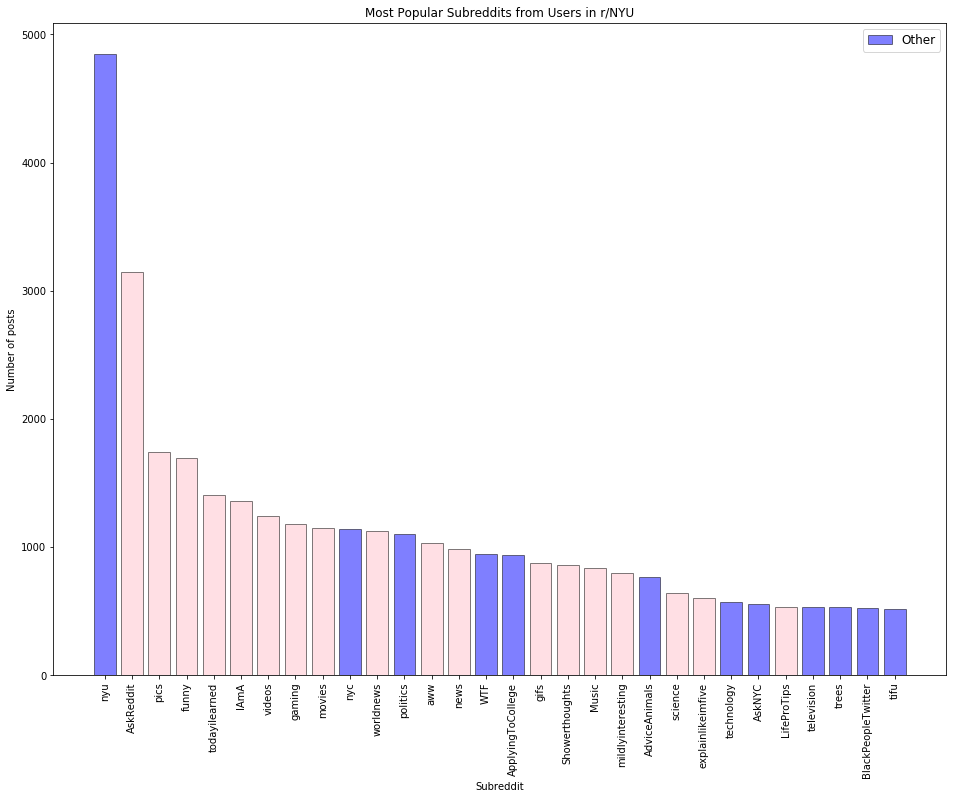

In [151]:
#list of defaults subreddits that users are subscribed to and the number of posts
defaults = ['AskReddit','funny','pics','todayilearned','gaming','videos','IAmA','worldnews','news','aww','gifs','movies',
'mildlyinteresting','Showerthoughts','Music','science','explainlikeimfive','LifeProTips','personalfinance']
subreds = subreddits['subreddit'].value_counts().index.tolist()[:30]
other_subred = subreddits['subreddit'].value_counts().tolist()[:30]
other_user = subreddits['subreddit'].value_counts().index.tolist()[:30]
colors = []
for subred in other_user:
    if subred in defaults:
        colors.append('pink')
    else:
        colors.append('blue')       

fig = plt.figure(figsize=(16,12))
plt.bar(other_user, other_subred, align='center', 
        alpha=0.5, width = 0.8, color = colors, edgecolor = 'black')
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of posts')
plt.xlabel('Subreddit')
plt.title('Most Popular Subreddits from Users in r/NYU')
plt.legend(["Other","Default"], fontsize = "large")
plt.show()

# Naive-Approach
There has been lots of complaints regarding the state of the NYU subreddit. Most of the posts are about admissions
and test scores. We want to understand that this recent phenomena about the current state of the NYU subreddit
is true. We then carry out two approaches to this.
1. Using matching text
2. Using [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and 
Scikit-Learn's [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering)

In [44]:
#Investigate if NYU subreddit is filled with application posts
common_words = ['application', 'essay', 'essays','ED1','EDII','admissions',
                'acceptance', 'acceptance rate','Internal Transfer','Transfer',
               'apply', 'applying', 'app','Application', 'applicant', 
                'applicants', 'apply to','ED', 'Chance me', 'Chances', 
                'ED 1','ED II','EDI']

count = 0 
titles = posts['title'].tolist()
contents = posts['content'].tolist()

#Creating a list with id to prevent duplicates values
applications = list()

#Check both title and content of post
for index, row in posts.iterrows():
    if any(word in row['title'] for word in common_words):
        applications.append(row['id'])
        count+=1
        
for index, row in posts.iterrows():
    if row['id'] not in applications:
        if any(word in row['content'] for word in common_words):
            count+=1
            
#To Do: Plot this value against the number of posts in NYU subreddit        
print('Post about application: ', str(count))

Post about application:  1483


In [45]:
#How many time is Stern mentions in both posts and comments
words = ['Stern','stern','sternie']
post_count = 0
comment_count = 0
posts_stern = posts['content'].tolist()
for content in contents:
    if any(word in content for word in words):
        post_count += 1
        
comments_stern = comments['content'].tolist()
for comment in comments_stern:
    if any(word in comment for word in words):
        comment_count += 1
        
print(str(post_count), 'posts about Stern and ', str(comment_count), 'comments about Stern')

250 posts about Stern and  951 comments about Stern


# Categorizing Content

We will categorize all of r/NYU's posts into different groups. 
No posts are labeled already, and in fact the categories are not defined yet. 
We will be using [Scikit-Learn's KMeans algorithm](https://en.wikipedia.org/wiki/K-means_clustering), 
which requires us to properly prepare 
our text dataset and create a [TF-IDF matrix](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). This will be an example of unsupervised machine learning, 
as we do not have a labeled dataset to test the KMeans model.


We define a function to clean up our text. 
This function breaks a line into tokens,
and removes stopwords, which are words that don't add anything to the post's 
meaning (i.e. articles). This effectively sanitizes our text and makes it about 
as uniform as possible.

In [46]:
#Approach 2: Using NLTK library
stopword = set(stopwords.words('english'))

def clear_filler(content):
    word_token = word_tokenize(content)
    sentence = [w for w in word_token if not w in stopword] 
    return ' '.join(sentence)

In [47]:
#Cleaning up the title and content and added as a new column in the dataframe
title_clean = posts['title'].apply(clear_filler)
content_clean = posts['content'].apply(clear_filler)

posts['doc'] = title_clean.map(str) + ' ' + content_clean

In order to create a TF-IDF matrix, we will use 
Scikit-Learn's 
[TfidfVectorizer package](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
Since we cleaned our data, all we have to do is create a new TfidfVectorizer, 
convert the post texts to a list and fit the vectorizer, and construct a 
new dataframe from the result. We can also implement this ourself using
online tutorials. However, that would take too long but certainly fun to try out later on                



In [49]:
#Creating TF-IDF matrix using NLTK TF-IDF Vectorizer
titles = posts['title'].tolist()
docs = posts['doc'].tolist()

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(docs)
posts_tfidf = pd.DataFrame(X.T.todense(), index=vectorizer.get_feature_names(), columns = titles)

posts.head(5)

,id,name,url,title,content,score,created_utc,permalink,link_flair_text,class,sentiment,doc
0,ehaes3,somedude297,https://www.reddit.com/r/nyu/comments/ehaes3/i...,Internal Transfer to Stern,What is the word count for the personal statem...,1,1.577649e+09,/r/nyu/comments/ehaes3/internal_transfer_to_st...,None,Course Information,neutral,Internal Transfer Stern What word count person...
1,ehacsf,skt_fekar,https://www.reddit.com/r/nyu/comments/ehacsf/a...,Are electives generally harder than the requir...,I just took my last required course (Basic Alg...,1,1.577648e+09,/r/nyu/comments/ehacsf/are_electives_generally...,None,general NYU,neutral,Are electives generally harder required course...
2,eha7dc,Funkphlex,https://v.redd.it/uqbufxdpgm741,BYOB-friendly New Years Eve Dance Party & Vari...,,6,1.577648e+09,/r/nyu/comments/eha7dc/byobfriendly_new_years_...,None,general NYU,positive,BYOB-friendly New Years Eve Dance Party & Vari...
3,eh7v8h,sarampagnepapi,https://www.reddit.com/r/nyu/comments/eh7v8h/l...,last min photographers in manhattan?,im here until jan 1st and im looking for a sup...,1,1.577637e+09,/r/nyu/comments/eh7v8h/last_min_photographers_...,None,general NYU,positive,last min photographers manhattan ? im jan 1st ...
4,eh7hnm,jerseyskies,https://www.reddit.com/r/nyu/comments/eh7hnm/i...,is it okay if i tuen in my film portfolio today?,i know they said at least 2 weeks prior to the...,1,1.577635e+09,/r/nyu/comments/eh7hnm/is_it_okay_if_i_tuen_in...,None,general NYU,positive,okay tuen film portfolio today ? know said lea...


We then use Scikit-Learn's KMeans function to split the data up into clusters based on similarities in text from the TF-IDF matrix.

Unfortunately, KMeans is a non-deterministic algorithm, meaning that it will give a different result if run multiple times. This can lead to some interesting results, as the clusters change each time the algorithm is run. This can be alleviated by providing an integer for a random seed, which will cause the KMeans to give the same result every time. Though the selection is trivial, we have chosen 728 as our random seed.

Here we are specifying k = 15 to categorize the data into 15 clusters. We will manually inspect each cluster to see which posts in each cluster have in common, and name them appropriately

In [50]:
# using KMeans, cluster the data into a set number of categories
true_k = 15
r = 728 # KMeans is non-deterministic unless we specify the random seed
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state = r)

# fit the model
model.fit(X)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 game
 play
 nyu
 design
 games
 team
 soccer
 league
 club
 center
Cluster 1:
 sat
 gpa
 school
 ap
 year
 nyu
 high
 scores
 score
 chances
Cluster 2:
 nyu
 know
 new
 looking
 like
 does
 thanks
 campus
 need
 student
Cluster 3:
 summer
 housing
 looking
 nyu
 room
 apartment
 living
 campus
 dorms
 sublet
Cluster 4:
 removed
 nyu
 free
 students
 looking
 college
 help
 paid
 girls
 student
Cluster 5:
 aid
 financial
 nyu
 scholarships
 got
 package
 international
 scholarship
 question
 tuition
Cluster 6:
 nyu
 school
 like
 know
 students
 student
 want
 college
 really
 people
Cluster 7:
 major
 cas
 econ
 cs
 double
 math
 stern
 nyu
 minor
 steinhardt
Cluster 8:
 tisch
 film
 school
 writing
 program
 nyu
 dramatic
 tv
 know
 want
Cluster 9:
 program
 nyu
 liberal
 studies
 applying
 students
 like
 got
 know
 masters
Cluster 10:
 class
 classes
 course
 semester
 taken
 taking
 professor
 credit
 nyu
 courses
Cluster 11:
 job
 nyu
 work
 inte

After looking at the clusters, we have decided on some appropirate titles for each group. However, based on
our datasets, we learn that there is only a few handful interesting clusters. We define them below

In [16]:
cluster_names = {0: 'game', 1: 'NYU ', 2: 'general NYU', 3: 'Housing', 
                 4: 'School/Transfer', 5: 'Stern/Transfer', 6: 'NYU program/students', 7: 'New Experience/People',
                 8: 'Summer Housing/Internship', 9:'Application (high school student)', 10: 'Financial Aid',
                11:'Study Abroad',12:'CS CAS/Tandon', 13:'Course Information'}

In [17]:
# Unwraps the prediction from the model and looks up the category string in the dictionary, as well as grouping
# classifications with similar characteristics.
def classify(post) :
    Y = vectorizer.transform([post])
    prediction = model.predict(Y)[0]
    if prediction == 13 :
        prediction = 12
    if prediction > 13:
        prediction = 13
    return prediction

In [18]:
#create random sample of dataframe
sample = posts.sample(n=40)
header_str = '~~~~~~~~~~'
#sample = df
pred = []
#add column for the prediction to the dataframe
for row in sample.iterrows() : 
    pred.append(classify(row[1]['doc']))
sample['pred'] = pred
#display sample posts by subject
for i in range(0,9) :
        print()
        print(header_str,cluster_names[i],header_str)
        sub = sample[sample['pred'] == i]
        for row in sub.iterrows() :
            print(row[1]['title'])


~~~~~~~~~~ game ~~~~~~~~~~
A message from r/Hofstra...

~~~~~~~~~~ NYU  ~~~~~~~~~~

~~~~~~~~~~ general NYU ~~~~~~~~~~
Be a founding member of Alpha Chi Rho at NYU!
STOP CHOOSING REPLY ALL ESPECIALLY TO TELL EVERYBODY ELSE TO STOP REPLY ALL-ING, YOU WALNUTS
dean's list
ED1 response?
Soros funded child rape ring protected by Trump for $4 billion bribe, Pelosi $3b. Participants include Obama, Schumer, Cuomo, Buttgieg, DeBlasio, Theil, Dorsey, Bill Murray. Over 60+ deaths from rapes, billions in payoffs. Listen to them do it here:
NYU Commencement 2017--Pharrell WIlliams Remarks
Just accepted my admission to NYU and joined the debt train
Ed ll
On campus jobs spring 2020
BUYING: Freshman textbooks
Sprint Speed Test: Anyone care to oblige?
Real Humans of New York
Company Contact Numbers At Your Fingertips With Flaptor - Flaptor
Does the Starbucks next to Steinhardt/Stern take Dining Dollars for non-food items?
Can we bring dogs into lectures?
Carlyle Court
Any thoughts on professor leffer



In [51]:
#Classify each content and title with the right label
classifications = []

# add classification for every row
for index, row in posts.iterrows() :
    doc = row['doc']
    classifications.append(cluster_names[classify(doc)])
posts['class'] = classifications
posts.head(5)

,id,name,url,title,content,score,created_utc,permalink,link_flair_text,class,sentiment,doc
0,ehaes3,somedude297,https://www.reddit.com/r/nyu/comments/ehaes3/i...,Internal Transfer to Stern,What is the word count for the personal statem...,1,1.577649e+09,/r/nyu/comments/ehaes3/internal_transfer_to_st...,None,Course Information,neutral,Internal Transfer Stern What word count person...
1,ehacsf,skt_fekar,https://www.reddit.com/r/nyu/comments/ehacsf/a...,Are electives generally harder than the requir...,I just took my last required course (Basic Alg...,1,1.577648e+09,/r/nyu/comments/ehacsf/are_electives_generally...,None,general NYU,neutral,Are electives generally harder required course...
2,eha7dc,Funkphlex,https://v.redd.it/uqbufxdpgm741,BYOB-friendly New Years Eve Dance Party & Vari...,,6,1.577648e+09,/r/nyu/comments/eha7dc/byobfriendly_new_years_...,None,general NYU,positive,BYOB-friendly New Years Eve Dance Party & Vari...
3,eh7v8h,sarampagnepapi,https://www.reddit.com/r/nyu/comments/eh7v8h/l...,last min photographers in manhattan?,im here until jan 1st and im looking for a sup...,1,1.577637e+09,/r/nyu/comments/eh7v8h/last_min_photographers_...,None,general NYU,positive,last min photographers manhattan ? im jan 1st ...
4,eh7hnm,jerseyskies,https://www.reddit.com/r/nyu/comments/eh7hnm/i...,is it okay if i tuen in my film portfolio today?,i know they said at least 2 weeks prior to the...,1,1.577635e+09,/r/nyu/comments/eh7hnm/is_it_okay_if_i_tuen_in...,None,general NYU,positive,okay tuen film portfolio today ? know said lea...


In [58]:
terms = {}
for key, value in cluster_names.items():
    terms[value] = 0

# tally up each category
for index, row in posts.iterrows() :
    terms[row['class']] += 1

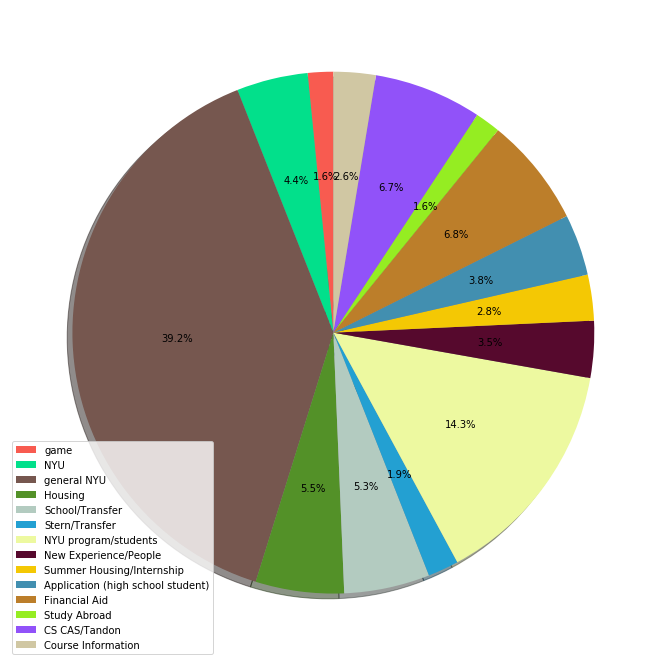

In [108]:
# Create temporary dataframe for use of Plotly
df_temp = pd.DataFrame()
df_temp['classification'] = terms.keys()
df_temp['count'] = terms.values()

colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colour = colors(14)

fig = plt.figure(figsize=(16,12))
plt.pie(df_temp['count'], autopct='%1.1f%%', shadow=True, startangle= 90, colors = colour)
plt.legend(df_temp['classification'].tolist(), loc="lower left", fontsize = 'medium')
plt.show()

# Sentiment Analysis

Next, we will look at all the posts of r/NYU and analyze their sentiments, 
classifying them as positive, negative, or neutral.

To do this, we will use the Sentiment Analyzer library from
[VADER (Valence Aware Dictionary and Sentiment Reasoner) algorithm](https://github.com/cjhutto/vaderSentiment), 
which is a pre-trained model that specializes in sentiment analysis of social media posts.

The analyzer will give out scores based on the input string. We will use it accordingly based on posts and comments

In [23]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(content):
    score = analyzer.polarity_scores(content)
    if score['pos'] >= 0.05:
        return 'positive'
    if score['neg'] <= 0.05:
        return 'negative'
    else:
        return 'neutral'
    

In [24]:
sentiments = []
for index, row in posts.iterrows():
    sentiment = get_sentiment(row['title'] + ' ' + row['content'])
    sentiments.append(sentiment)

posts['sentiment'] = sentiments
posts.head(5)

,id,name,url,title,content,score,created_utc,permalink,link_flair_text,class,sentiment
0,ehaes3,somedude297,https://www.reddit.com/r/nyu/comments/ehaes3/i...,Internal Transfer to Stern,What is the word count for the personal statem...,1,1.577649e+09,/r/nyu/comments/ehaes3/internal_transfer_to_st...,None,Course Information,neutral
1,ehacsf,skt_fekar,https://www.reddit.com/r/nyu/comments/ehacsf/a...,Are electives generally harder than the requir...,I just took my last required course (Basic Alg...,1,1.577648e+09,/r/nyu/comments/ehacsf/are_electives_generally...,None,general NYU,neutral
2,eha7dc,Funkphlex,https://v.redd.it/uqbufxdpgm741,BYOB-friendly New Years Eve Dance Party & Vari...,,6,1.577648e+09,/r/nyu/comments/eha7dc/byobfriendly_new_years_...,None,general NYU,positive
3,eh7v8h,sarampagnepapi,https://www.reddit.com/r/nyu/comments/eh7v8h/l...,last min photographers in manhattan?,im here until jan 1st and im looking for a sup...,1,1.577637e+09,/r/nyu/comments/eh7v8h/last_min_photographers_...,None,general NYU,positive
4,eh7hnm,jerseyskies,https://www.reddit.com/r/nyu/comments/eh7hnm/i...,is it okay if i tuen in my film portfolio today?,i know they said at least 2 weeks prior to the...,1,1.577635e+09,/r/nyu/comments/eh7hnm/is_it_okay_if_i_tuen_in...,None,general NYU,positive
5,eh6zs6,bluethotiana,https://www.reddit.com/r/nyu/comments/eh6zs6/c...,Current High school Junior with a few questions,1. I heard that NYU has started a Data Science...,1,1.577633e+09,/r/nyu/comments/eh6zs6/current_high_school_jun...,None,New Experience/People,positive
6,eh4d8b,ContrabandParagon,https://www.reddit.com/r/nyu/comments/eh4d8b/w...,Why did you choose NYU?,,11,1.577614e+09,/r/nyu/comments/eh4d8b/why_did_you_choose_nyu/,None,NYU program/students,negative
7,eh3ao8,herefortheshibas,https://www.reddit.com/r/nyu/comments/eh3ao8/s...,Should I join Stern's AKPsi Business Frat?,I will be a freshman at Stern in the fall of 2...,1,1.577605e+09,/r/nyu/comments/eh3ao8/should_i_join_sterns_ak...,None,NYU program/students,positive
8,eh2vn9,hellasadgemini,https://www.reddit.com/r/nyu/comments/eh2vn9/t...,Theatre for non-majors?,"Hi, I'm currently finishing my EDII applicatio...",3,1.577602e+09,/r/nyu/comments/eh2vn9/theatre_for_nonmajors/,None,Summer Housing/Internship,negative
9,eh2sws,Ilovehashmaps,https://www.reddit.com/r/nyu/comments/eh2sws/h...,Has anyone successfully waived their Texts and...,I was checking [https://cas.nyu.edu/content/n...,4,1.577602e+09,/r/nyu/comments/eh2sws/has_anyone_successfully...,None,New Experience/People,positive


In [25]:
cmt_sentiments = []
for index, row in comments.iterrows():
    sentiment = get_sentiment(row['content'])
    cmt_sentiments.append(sentiment)

comments['sentiment'] = cmt_sentiments
comments.head(10)

,id,name,content,score,comment_id,link_id,created_utc,sentiment
0,fcg73yj,gdismypassion,It should totally be fine!!! Don’t worry about...,3,t3_eh7hnm,t3_eh7hnm,1.577637e+09,positive
1,fcg1xgv,anhonestscribbler,"Hey hey. Actual data scientist here (Math, CAS...",3,t3_eh6zs6,t3_eh6zs6,1.577636e+09,neutral
2,fch9z98,sh1teinthebus,"if u want to do anything business related, ste...",1,t3_eh6zs6,t3_eh6zs6,1.577649e+09,positive
3,fcg9jda,bluethotiana,I saw that a lot of the courses in the CAS Dou...,1,t1_fcg1xgv,t3_eh6zs6,1.577638e+09,positive
4,fchanad,None,[deleted],1,t1_fch9z98,t3_eh6zs6,1.577649e+09,negative
5,fcgc6iz,anhonestscribbler,"I’m sorry, are you asking if triple majoring i...",2,t1_fcg9jda,t3_eh6zs6,1.577639e+09,positive
6,fchg2rg,sh1teinthebus,u mentioned finance which stern is arguably #1...,1,t1_fchanad,t3_eh6zs6,1.577650e+09,positive
7,fchg5i7,sh1teinthebus,might as well shoot ur shot at stern is basica...,1,t1_fchanad,t3_eh6zs6,1.577650e+09,positive
8,fcgchza,bluethotiana,So then should I double major in Data Science ...,1,t1_fcgc6iz,t3_eh6zs6,1.577639e+09,positive
9,fcge2me,anhonestscribbler,"No idea, honestly. You’re young. You’ll figure...",2,t1_fcgchza,t3_eh6zs6,1.577639e+09,positive


In [26]:
#Get the total sentiments of posts and comments total
post_dict = posts['sentiment'].value_counts().to_dict()
cmt_dict = comments['sentiment'].value_counts().to_dict()

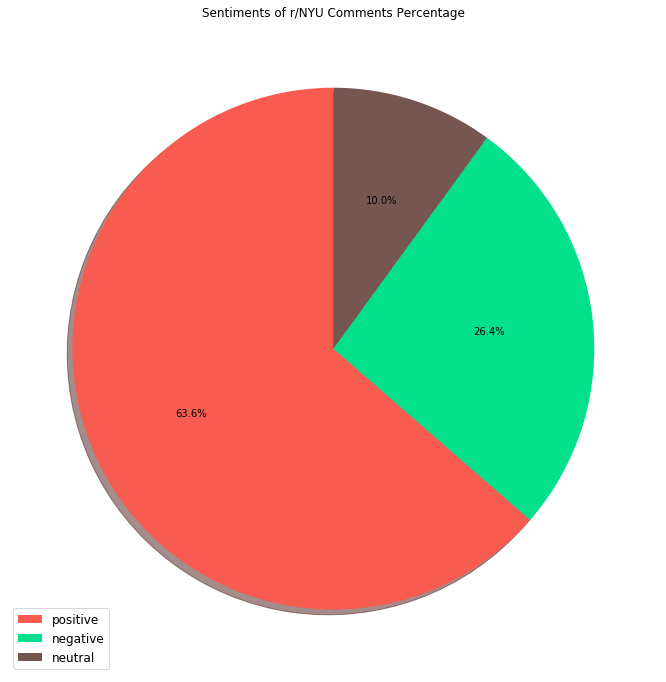

In [176]:
#Pie plot of the sentiment percentage
fig = plt.figure(figsize=(16,12))
plt.pie(list(cmt_dict.values()), autopct='%1.1f%%', shadow=True, startangle= 90, colors = colour)
plt.legend(list(cmt_dict.keys()), loc="lower left", fontsize = 'large')
plt.title('Sentiments of r/NYU Comments Percentage')
plt.show()

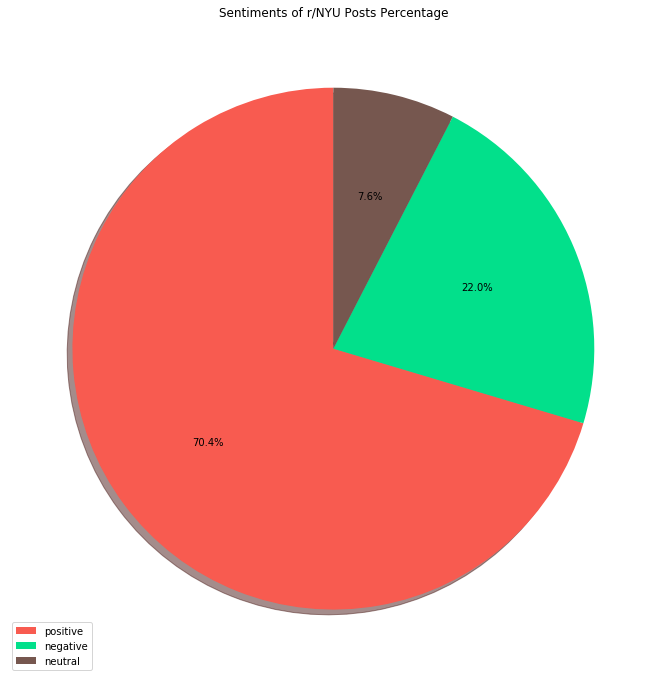

In [173]:
#Pie plot of the sentiment percentage
fig = plt.figure(figsize=(16,12))
plt.pie(list(post_dict.values()), autopct='%1.1f%%', shadow=True, startangle= 90, colors = colour)
plt.legend(list(post_dict.keys()), loc="lower left", fontsize = 'medium')
plt.title('Sentiments of r/NYU Posts Percentage')
plt.show()

This pie chart shows us that most of the posts and comments in r/NYU tend to have a positive sentiment.

# Fun Plots/Facts

## Users with the best/worst reddit karmas

In [156]:
users_ls = users['name'].tolist()
scores = {user : 0 for user in users_ls}

#Get the score from posts dataframe
for index, row in posts.iterrows():
    user = row['name']
    if user in scores:
        scores[user] += row['score']

#Get the score from comments dataframe        
for index, row in comments.iterrows():
    user = row['name']
    if user in scores:
        scores[user] += row['score']

def get_value(k):
    return scores[k]

In [30]:
worst_users = sorted(scores, key = get_value, reverse = False)[:10]
worst_scores = list()
for user in worst_users:
    worst_scores.append(scores[user])

worst_posters = pd.DataFrame({'User': worst_users, 'Karma': worst_scores})
worst_posters

,User,Karma
0,loljknosrs,-65
1,DigitalDash123,-41
2,umadBroololol,-29
3,gym_thief_69,-28
4,financewb,-28
5,watchpom,-28
6,fantasy393939,-28
7,sahandree20,-26
8,andidiong1739,-25
9,nwhyyou,-25


                   User  Karma
0                  None   4680
1                Impune   3030
2                Conpen   1453
3            sokpuppet1    787
4           doneanddead    529
5      KenyaAirwaysAnon    448
6             lolmonger    429
7        Wherearemylegs    424
8          hardwaregeek    420
9        Iambikecurious    415
10            memento15    403
11            mrmbuceta    356
12  ahhhhhhhhhthrowaway    355
13     IgglePiggle69420    328
14      unqualifiedking    323


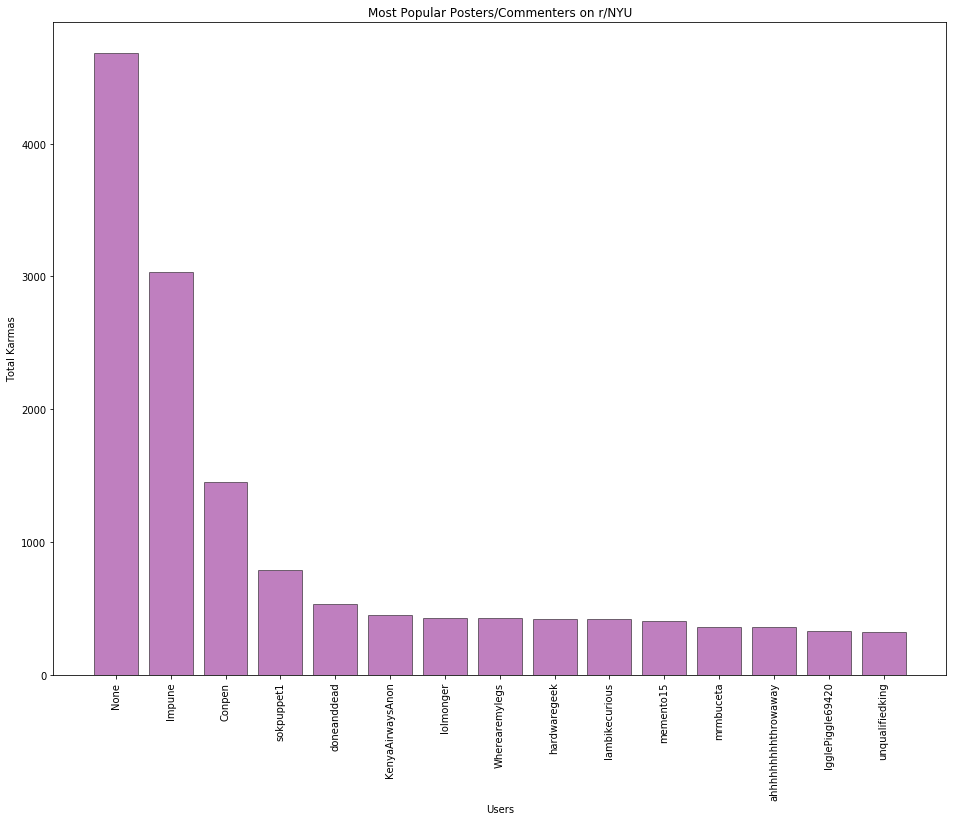

In [170]:
top_users = sorted(scores, key = get_value, reverse = True)[:15]
top_scores = list()
for user in top_users:
    top_scores.append(scores[user])

top_posters = pd.DataFrame({'User': top_users, 'Karma': top_scores})
print(top_posters)

fig = plt.figure(figsize=(16,12))
plt.bar(top_posters['User'], top_posters['Karma'], align='center', 
        alpha=0.5, width = 0.8, color = 'purple', edgecolor = 'black')
plt.xticks(rotation = 'vertical')
plt.ylabel('Total Karmas')
plt.xlabel('Users')
plt.title('Most Popular Posters/Commenters on r/NYU')
plt.show()

## Top 10 post with the highest reddit karma

In [33]:
top_posts = posts.sort_values(['score'], ascending = False).head(10)
standing = 1
for index, row in top_posts.iterrows():
    print('Number: ' + str(standing))
    print('Post Title: \"' + row['title'] + '\"')
    print('Author: ' + row['name'])
    print('Score: ' + str(row['score']))
    date_posted = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(row['created_utc']))
    print('Posted on: ' + date_posted )
    print('URL: ' + row['url'])
    print('---------------------------------------------')
    standing += 1

Number: 1
Post Title: "To the NYU students on the overnight from Nairobi to JFK: you were a fucking embarrassment and disgrace."
Author: KenyaAirwaysAnon
Score: 448
Posted on: 2019-03-24 09:15:59
URL: https://www.reddit.com/r/nyu/comments/b4w826/to_the_nyu_students_on_the_overnight_from_nairobi/
---------------------------------------------
Number: 2
Post Title: "Congrats class of 2019!!!"
Author: cxavier
Score: 219
Posted on: 2019-05-22 15:10:36
URL: https://i.imgur.com/3eYztEz.gif
---------------------------------------------
Number: 3
Post Title: "Got banned for posting this earlier"
Author: imsh9381
Score: 207
Posted on: 2019-10-16 11:27:02
URL: https://i.redd.it/e4no0uzk8xs31.jpg
---------------------------------------------
Number: 4
Post Title: "Congrats NYU 2018! Here's a picture I took of the Empire State Building lit up in violet last night."
Author: skier
Score: 196
Posted on: 2018-05-16 22:09:59
URL: https://i.redd.it/eoucptpvqby01.jpg
--------------------------------------

In [34]:
#Finding the parent posts of a comment
def find_parent(comment_id):
    comment_id = comment_id.split('_')[1]
    parent_url = 'Not Found'
    while comment_id in comments['id']:
        for index, row in comments.iterrows():
            if(item == row['id']):
                comment_id = row['id']
                
    for index, row in posts.iterrows():
        if row['id'] == comment_id:
            parent_url = row['url']
    return parent_url

## Top 10 best/worst comments in NYU subreddit

In [35]:
#Function to find the top 10 best/worst comments in NYU subreddit
def find_mojo(best):
    order = None
    if best is True:
        order = False
    else:
        order = True
    
    bottom_comments = comments.sort_values(['score'], ascending = order).head(10)
    standing = 1
    for index, row in bottom_comments.iterrows():
        print('Number: ', str(standing))
        print('Comment: \"', row['content'], '\"')
        print('Posted By: ', row['name'])
        print('Score: ', str(row['score']))
        date_posted = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(row['created_utc']))
        print('Posted on: ' + date_posted)
        print('Parent post:', find_parent(row['comment_id']))
        print('------------------------------------------')
        standing += 1

In [36]:
find_mojo(True)

Number:  1
Comment: " Fuckin Stern kids  "
Posted By:  tricksta616
Score:  136
Posted on: 2019-03-24 09:23:00
Parent post: https://www.reddit.com/r/nyu/comments/b4w826/to_the_nyu_students_on_the_overnight_from_nairobi/
------------------------------------------
Number:  2
Comment: " Gonna gently suggest that it’s saying things and acting like this that make it hard to make friends:

https://www.reddit.com/r/nyu/comments/e1uhdq/does_anyone_here_dislike_some_international/f8tr573/

Your [other posts](https://www.reddit.com/user/ilscilsc) calling people morons, retarded, bastards, trash, etc don’t endear you either. 

Look, it’s clear you got some issues, so I’m somewhat sympathetic, but maybe being nicer to people and not being so quick to insult folks would help you make better connections. "
Posted By:  sokpuppet1
Score:  109
Posted on: 2019-11-27 07:56:46
Parent post: https://www.reddit.com/r/nyu/comments/e2de47/dont_want_to_spend_another_thanksgiving_alone_rant/
---------------------

In [37]:
find_mojo(False)            

Number:  1
Comment: " happy 😃 9/11 😽 you sexy 😼 sluts 😍 today 📆 is the day 🤙 the twins 👯 got aborted 🤰 share 👐 with 10 🔟 patriots 🎩 🇺🇸 for another ➿ abortion ✈ 🏙 and be 🐝 a true 💯 american 🦅 do NOT 🚫 share 👐 and you 👈 WILL 😮 become 😩 an infidel 👳 "
Posted By:  Boy_314
Score:  -51
Posted on: 2018-09-11 11:15:41
Parent post: https://www.reddit.com/r/nyu/comments/9ey8pq/weirdbad_roommate_stories/
------------------------------------------
Number:  2
Comment: " Lmao he's gay and she's a lesbian. I can't believe any of this. An older gay person will know if they like the other sex or not, she's like at least 60. He's a dumbass. If she wasn't a proud and out lesbian for decades I might have believed him "
Posted By:  zinko101
Score:  -34
Posted on: 2018-08-15 12:32:57
Parent post: http://gothamist.com/2018/08/14/female_nyu_professor_suspended.php
------------------------------------------
Number:  3
Comment: " im tryna transfer into wharton or sloan or harvard or yale or stanford or columbia

## First 10 posts on NYU subreddit

In [38]:
first_posts = posts.sort_values(['created_utc'], ascending = [True]).head(10)
standing = 1
for index, row in first_posts.iterrows():
    print('Number: ' + str(standing))
    print('Post Title: \"' + row['title'] + '\"')
    print('Author: ' + row['name'])
    print('Score: ' + str(row['score']))
    date_posted = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(row['created_utc']))
    print('Posted on: ' + date_posted)
    print('URL: ' + row['url'])
    print('---------------------------------------------')
    standing += 1

    
first_post = posts.sort_values(['created_utc'], ascending = True).head(1)
form = '%Y-%m-%d'
fpost_date = time.strftime('%Y-%m-%d', time.localtime(first_post['created_utc']))
fpost_date = datetime.strptime(fpost_date, form)
created_date = datetime(2009,11,4)
diff = fpost_date - created_date
diff = diff.days
curr = diff
year = 0
while(curr > 0):
    curr = diff - 365
    if curr >= 0:
        year += 1
        diff = curr
print('\nFirst post created: ' + str(year) + ' year and ' + str(diff) + ' days after the subreddit was created')    


Number: 1
Post Title: "No NYU love?"
Author: no_pun_intendid
Score: 5
Posted on: 2010-11-28 12:23:51
URL: https://www.reddit.com/r/nyu/comments/ecwp1/no_nyu_love/
---------------------------------------------
Number: 2
Post Title: "Are most of you rich?"
Author: YouBestBeTrollin
Score: 1
Posted on: 2010-11-30 19:36:54
URL: https://www.reddit.com/r/nyu/comments/ee7am/are_most_of_you_rich/
---------------------------------------------
Number: 3
Post Title: "So, I go to Stevens in Hoboken..."
Author: TODizzle91
Score: 4
Posted on: 2010-12-04 20:20:34
URL: https://www.reddit.com/r/nyu/comments/egcla/so_i_go_to_stevens_in_hoboken/
---------------------------------------------
Number: 4
Post Title: "Procrastination from Finals!"
Author: sallyNYU
Score: 4
Posted on: 2010-12-09 18:53:37
URL: https://www.reddit.com/r/nyu/comments/ej8a1/procrastination_from_finals/
---------------------------------------------
Number: 5
Post Title: "Are you a Flash programmer or do you know a Flash programmer wh

It is interesting to note that while r/NYU itself was created on November 4th, 2009, 
it appears that the first post was not made until November 28th, 2010.
which is 1 year and 24 days after the subreddit was created